In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
import math
import pandas as pd

In [2]:
#Contour plot for beale function
def contour_beales_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=beales_function(np.array([x,y]),features=0,target=0)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(3,0.5, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig,ax


#Utility to plot beales contours
def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r", xlimL=1, xlimH=1, ylimL=1, ylimH=1, zlimL=2, zlimH=2):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-xlimL, xlimH)
    ax.set_ylim(-ylimL, ylimH)
    ax.set_zlim(-zlimL, zlimH)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;



def overlay_trajectory(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=14)
    return ax;


##Beale function

$$
z = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2
$$

With absolute minimum in 

$$(\hat{x},\hat{y})=(3,0.5)$$

In [3]:
#Beale function
def beales_function(theta,features,target):
    x=theta[0]
    y=theta[1]
    return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    

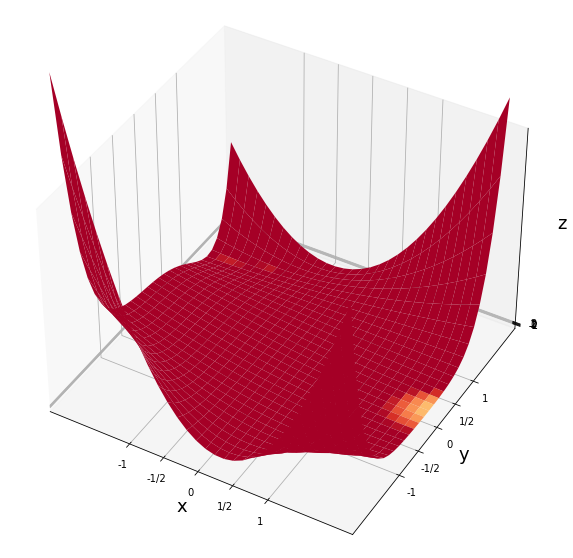

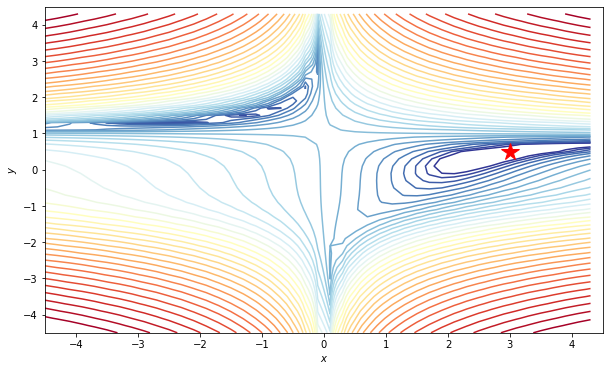

In [4]:
#Plot 3D Beale function
x, y = np.mgrid[-2:2:31j, -2:2:31j] 
fig,ax=plot_surface(x,y,beales_function(np.array([x,y]),features=0,target=0),xlimL=2.1, xlimH=2.1, ylimL=2.1, ylimH=2.1, zlimL=0,zlimH=300)

#Beale function contour plot
fig1,ax1 =contour_beales_function()
plt.show()

##PER ANIMARE IL PLOT
https://towardsdatascience.com/gradient-descent-animation-1-simple-linear-regression-e49315b24672

#Approaching Gradient Descent

##Define updating thetas functions

In [5]:
def vanilla_descent(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p):
  
  grad=gradient(target,features,theta)
  theta=theta-lr*grad
  return [theta,0]

In [6]:
def RK_2_adaptive_gradient(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p):
  g=gradient(target,features,theta)
  theta_hat=theta-lr*g
  g_tilde=gradient(target,features,theta_hat)
  
  prod=np.dot(np.reshape((g-g_tilde),(g.shape[0])), np.reshape((g),(g.shape[0])))
  
  tentative= 2*lr*prod/(np.linalg.norm(g-g_tilde)**2)
  if prod>0:
    lr_opt=tentative
  else:
    lr_opt=lr

  if lr_opt>=lr:
    lr=beta*lr+(1-beta)*lr_opt
  else:
    lr=(1-beta)*lr_opt
  
  theta=theta-lr*g
  
  return [theta,0]

In [7]:
def RK4(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p): #theta=[x0,y0] 
    c =  0.003 #lr*100 #da capire come inizializzare c
    lr = (c/n_iter**(1/5))
    
    k1 = lr*gradient(target,features,theta)

    theta0 = theta - (1/2*lr*k1)
    k2=lr*gradient(target,features,theta)
    
    
    theta0 -= (1/2*lr*k2)
    k3 = lr*gradient(target,features,theta)
    
    theta0 -= (1/2*lr*k3)
    k4 = lr*gradient(target,features,theta)
    
    gradi = (k1/6 + k2/3 + k3/3 + k4/6)#*lr
    theta = theta - (gradi)
    
    return [theta,0]

In [8]:
#https://towardsdatascience.com/learning-parameters-part-2-a190bef2d12
def NAG (theta, target,features,lr,loss, gradient_f, beta, n_iter, t, theta_p): #t=a quale iterazione stiamo, theta_previous=theta_{t-1}-->s_{t-1}
    mu_s = [0.999,0.995,0.99,0.9,0] 
    mu_max = mu_s[-2]               #aumentando mu_max migliora al convergenza
    mu = min(1-2**(-1-math.log2(t/250 +1)), mu_max) #https://towardsdatascience.com/learning-parameters-part-4-6a18d1d3000b
    
    theta_a = theta - mu*theta_p
    update_t = mu * theta_p  + lr*gradient_f(target,features,theta_a)
    theta = theta - update_t
    
    return [theta, update_t]


##Define gradient function

In [9]:
def beales_gradient(target,features,theta):
  x=theta[0]
  y=theta[1]
  grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
  grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
  grad=np.array([grad_x,grad_y])
  
  return(grad)

##Define gradient ascent function

In [10]:
def gradient_descent(theta, features, target, lr, num_steps,loss,GD_type,gradient_function,beta, n_iter,t, theta_p):
    
    loss_history = np.zeros(num_steps)
    parameter_traj=np.zeros((num_steps,theta[0].shape[0]))


    for step in range(num_steps):
        parameter_traj[step]=np.reshape(theta[0],theta[0].shape[0])
        loss_history[step]=loss(theta[0],features,target)
        theta = GD_type(theta[0], target, features, lr,loss,gradient_function,beta,n_iter,t=step, theta_p=theta[1])
        
    return theta, loss_history, parameter_traj

##Test different updating functions

# NOISE

In [11]:
#Beale function
def noisy_beales_function(theta,features,target):
    mu,var = 20,5
    x=theta[0]
    y=theta[1]
    z=np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    return z + np.random.normal(mu,var,1)

In [12]:
# Initialize theta0
#inizializzazioni da dove convergiamo meglio
#[-1,-1],[3,-3],[3,3],[-1,-4]


theta0 = [np.array([3,-2]),0]


# Run Gradient Ascent method
n_iter=100
theta_final_vanilla, log_l_history_vanilla,descent_trajectory_vanilla = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                        num_steps=n_iter,loss=noisy_beales_function,
                                                        GD_type=vanilla_descent,gradient_function=beales_gradient,
                                                        beta=0.01,n_iter=n_iter,t=0, theta_p=0)

theta_final_NAG, log_l_history_NAG,descent_trajectory_NAG = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=noisy_beales_function,
                                                   GD_type=NAG,gradient_function=beales_gradient,
                                                   beta=0.01,n_iter=n_iter,t=0, theta_p=0)

theta_final_RK4, log_l_history_RK4,descent_trajectory_RK4 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=noisy_beales_function,
                                                   GD_type=RK4,gradient_function=beales_gradient,
                                                   beta=0.01,n_iter=n_iter,t=0, theta_p=0)

theta_final_RK2, log_l_history_RK2,descent_trajectory_RK2 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=noisy_beales_function,
                                                   GD_type=RK_2_adaptive_gradient,gradient_function=beales_gradient,
                                                   beta=0.01, n_iter=n_iter,t=0, theta_p=0)

print(theta_final_RK2, theta_final_RK4, theta_final_NAG, theta_final_vanilla)


[array([2.92202188, 0.48560286]), 0] [array([2.44671571, 0.33304766]), 0] [array([ 2.51177701, -0.421304  ]), array([ 0.00162412, -0.00322695])] [array([ 2.62478728, -0.66673803]), 0]


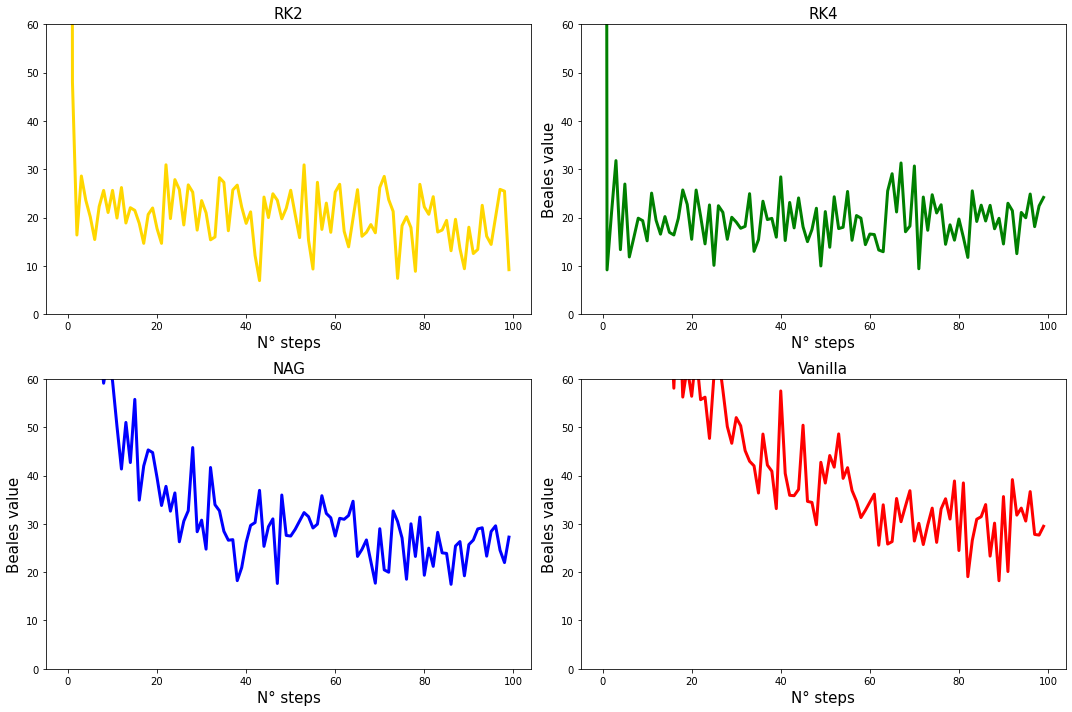

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.plot(log_l_history_RK2,color="gold",linewidth=3)
ax1.set_title("RK2",fontsize=15)
ax1.set_xlabel("N° steps",fontsize=15)
ax1.set_ylabel("Beales value",fontsize=15)
ax1.set_ylim([0, 60])

ax2.plot(log_l_history_RK4,color="green",linewidth=3)
ax2.set_title("RK4",fontsize=15)
ax2.set_ylabel("Beales value",fontsize=15)
ax2.set_xlabel("N° steps",fontsize=15)
ax2.set_ylim([0, 60])

ax3.plot(log_l_history_NAG,color="blue",linewidth=3)
ax3.set_title("NAG",fontsize=15)
ax3.set_ylabel("Beales value",fontsize=15)
ax3.set_xlabel("N° steps",fontsize=15)
ax3.set_ylim([0, 60])

ax4.plot(log_l_history_vanilla,color="red",linewidth=3)
ax4.set_title("Vanilla",fontsize=15)
ax4.set_xlabel("N° steps",fontsize=15)
ax4.set_ylabel("Beales value",fontsize=15)
ax4.set_ylim([0, 60])

fig.tight_layout()


plt.show()

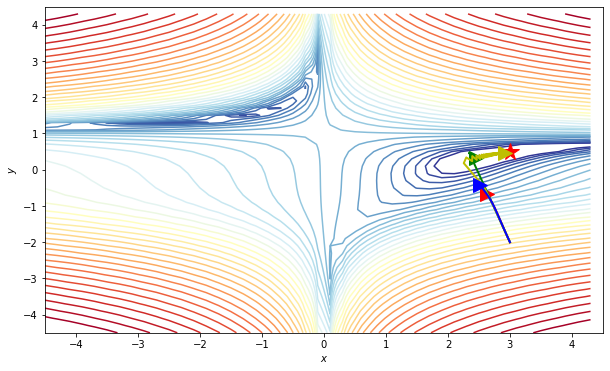

In [14]:
fig1, ax1=contour_beales_function()
overlay_trajectory(ax1,descent_trajectory_vanilla, 'Vanilla','r')
overlay_trajectory(ax1,descent_trajectory_RK4, 'RK','g')
overlay_trajectory(ax1,descent_trajectory_RK2, 'RK','y')
overlay_trajectory(ax1,descent_trajectory_NAG, 'NAG','b')

plt.show()



RISULTATI PER NOISE = 5 (MU=0,SIGMA=5), NSTEPS=100, PUNTO DI PARTENZA (3,-2) ---> METODI RK2 E 4 (SOPRATTUTTO 2) MOLTO + noise consistent perchè si avvicinano al minimo già alle prime iterazioni

# Studio rate convergenza

In [15]:
def vanilla_descent(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p,tol):
  
  grad=gradient(target,features,theta)
  theta=theta-lr*grad
  return [theta,0]

In [16]:
def RK_2_adaptive_gradient(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p,tol):
  g=gradient(target,features,theta)
  theta_hat=theta-lr*g
  g_tilde=gradient(target,features,theta_hat)
  
  prod=np.dot(np.reshape((g-g_tilde),(g.shape[0])), np.reshape((g),(g.shape[0])))
  
  tentative= 2*lr*prod/(np.linalg.norm(g-g_tilde)**2)
  if prod>0:
    lr_opt=tentative
  else:
    lr_opt=lr

  if lr_opt>=lr:
    lr=beta*lr+(1-beta)*lr_opt
  else:
    lr=(1-beta)*lr_opt
  
  theta=theta-lr*g
  
  return [theta,0]

In [17]:
def RK4(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p,tol): #theta=[x0,y0] 
    c = lr*100 #0.003 da capire come inizializzare c
    lr = (c/n_iter**(1/5))
    
    k1 = lr*gradient(target,features,theta)

    theta0 = theta - (1/2*lr*k1)
    k2=lr*gradient(target,features,theta)
    
    
    theta0 -= (1/2*lr*k2)
    k3 = lr*gradient(target,features,theta)
    
    theta0 -= (1/2*lr*k3)
    k4 = lr*gradient(target,features,theta)
    
    gradi = (k1/6 + k2/3 + k3/3 + k4/6)#*lr
    theta = theta - (gradi)
    
    return [theta,0]

In [18]:
#https://towardsdatascience.com/learning-parameters-part-2-a190bef2d12
def NAG (theta, target,features,lr,loss, gradient_f, beta, n_iter, t, theta_p,tol): #t=a quale iterazione stiamo, theta_previous=theta_{t-1}-->s_{t-1}
    mu_s = [0.999,0.995,0.99,0.9,0] 
    mu_max = mu_s[-2]               #aumentando mu_max migliora al convergenza
    mu = min(1-2**(-1-math.log2(t/250 +1)), mu_max) #https://towardsdatascience.com/learning-parameters-part-4-6a18d1d3000b
    
    theta_a = theta - mu*theta_p
    update_t = mu * theta_p  + lr*gradient_f(target,features,theta_a)
    theta = theta - update_t
    
    return [theta, update_t]


In [19]:
def check_interval(theta, tolerance): 
    min=np.array([3,0.5])
    x=theta[0]
    y=theta[1]
    if (min[0]-tolerance <= x <= min[0]+tolerance) and (min[1]-tolerance <= y <= min[1]+tolerance):
        return True
    else:
        return False
                 

In [20]:
def gradient_descent(theta, features, target, lr, num_steps,loss,GD_type,gradient_function,beta, n_iter,t, theta_p,tolerance):
    
    loss_history = np.zeros(num_steps)
    parameter_traj=np.zeros((num_steps,theta[0].shape[0]))

    nsteps=0
    check=False
    first=0
    k=-1
    for step in range(num_steps):
        check=check_interval(theta[0],tolerance)
        if check==True and first ==0:
            #print(('converged in {} steps for dradient method = {}').format(nsteps,str(GD_type)))
            first+=1
            k=nsteps
        parameter_traj[step]=np.reshape(theta[0],theta[0].shape[0])
        loss_history[step]=loss(theta[0],features,target)
        theta = GD_type(theta[0], target, features, lr,loss,gradient_function,beta,n_iter,step, theta[1],tolerance)
        nsteps+=1
        
    #if first==0:
        #print('convergence failed... :(')
        
    return theta, loss_history, parameter_traj,k

In [64]:
# Initialize theta0
#inizializzazioni da dove convergiamo meglio
#[-1,-1],[3,-3],[3,3],[-1,-4]

tol = 1
van,nag,rk2,rk4=[],[],[],[]
for i in range(1000):
    x=np.random.uniform(-4,4)
    y=np.random.uniform(-4,4)
    theta0 = [np.array([x,y]),0]
    # Run Gradient Ascent method
    n_iter=1000
    theta_final_vanilla, log_l_history_vanilla,descent_trajectory_vanilla,k1 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                            num_steps=n_iter,loss=beales_function,
                                                            GD_type=vanilla_descent,gradient_function=beales_gradient,
                                                            beta=0.01,n_iter=n_iter,t=0, theta_p=0,tolerance=tol)
    van.append(k1)
    #print(theta_final_vanilla)
    
    theta_final_NAG, log_l_history_NAG,descent_trajectory_NAG,k2 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                       num_steps=n_iter,loss=beales_function,
                                                       GD_type=NAG,gradient_function=beales_gradient,
                                                       beta=0.01,n_iter=n_iter,t=0, theta_p=0,tolerance=tol)
    nag.append(k2)
    #print(theta_final_NAG)
    
    theta_final_RK4, log_l_history_RK4,descent_trajectory_RK4,k3 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                       num_steps=n_iter,loss=beales_function,
                                                       GD_type=RK4,gradient_function=beales_gradient,
                                                       beta=0.01,n_iter=n_iter,t=0, theta_p=0,tolerance=tol)
    rk4.append(k3)
    #print(theta_final_RK4)
          
    theta_final_RK2, log_l_history_RK2,descent_trajectory_RK2,k4 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                       num_steps=n_iter,loss=beales_function,
                                                       GD_type=RK_2_adaptive_gradient,gradient_function=beales_gradient,
                                                       beta=0.01, n_iter=n_iter,t=0, theta_p=0,tolerance=tol)
    
    rk2.append(k4)
    #print(theta_final_RK2)
    

/tmp/ipykernel_4768/3797063468.py:5: RuntimeWarning: overflow encountered in double_scalars
  return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
/tmp/ipykernel_4768/1564751610.py:4: RuntimeWarning: overflow encountered in double_scalars
  grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
/tmp/ipykernel_4768/3797063468.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
/tmp/ipykernel_4768/1564751610.py:4: RuntimeWarning: invalid value encountered in double_scalars
  grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
/tmp/ipykernel_4768/3797063468.py:5: RuntimeWarning: overflow encountered in square
  return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)


In [78]:
indexes=np.where(np.array(van)==(-1)) #indici per cui vanilla non converge -->li vogliamo levare anche dagli altri hist per fare un confronto serio

In [80]:
nag_comparison=np.delete(nag,indexes)
rk2_comparison=np.delete(rk2,indexes)
rk4_comparison=np.delete(rk4,indexes)

In [81]:
def remove_1(myList):
    myList = list(filter((-1).__ne__, myList))
    return myList

In [82]:
#leviamo i (-1)
van_complete=remove_1(van)
nag_complete=remove_1(nag)
rk2_complete=remove_1(rk2)
rk4_complete=remove_1(rk4)

## Visualize convergence rate

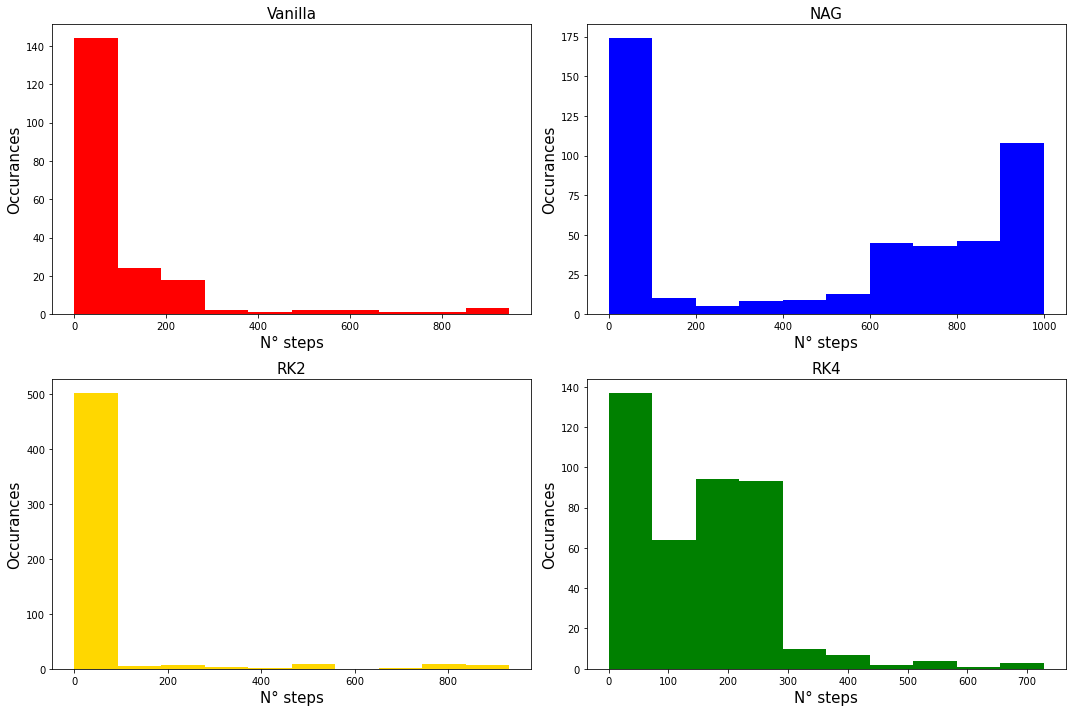

In [98]:
#Se vogliamo plottare tutte le volte che converge ciascuno
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.hist(van_complete, color = "red", density=False)
ax1.set_title("Vanilla",fontsize=15)
ax1.set_ylabel("Occurances",fontsize=15)
ax1.set_xlabel("N° steps",fontsize=15)

ax2.hist(nag_complete, color='blue',  density=False)
ax2.set_title("NAG",fontsize=15)
ax2.set_ylabel("Occurances",fontsize=15)
ax2.set_xlabel("N° steps",fontsize=15)

ax3.hist(rk2_complete,color='gold',   density=False)
ax3.set_title("RK2",fontsize=15)
ax3.set_ylabel("Occurances",fontsize=15)
ax3.set_xlabel("N° steps",fontsize=15)

ax4.hist(rk4_complete,color='green',  density=False)
ax4.set_title("RK4",fontsize=15)
ax4.set_ylabel("Occurances",fontsize=15)
ax4.set_xlabel("N° steps",fontsize=15)

fig.tight_layout()
plt.show()

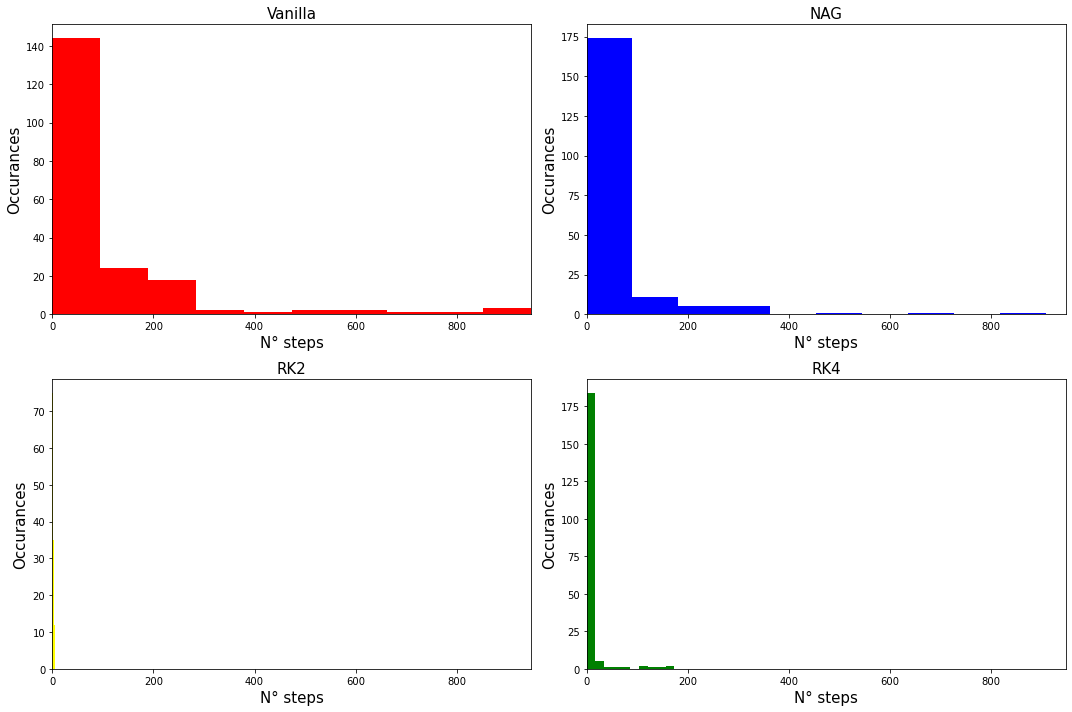

In [114]:
#Se vogliamo plottare tutte le volte che converge vanilla (convergono anche tutti gli altri tranne 1 valore di rk2 (SHHHHHH))
#qui quindi abbiamo sostanzialmente lo stesso numero di run in ogni plot (che ci permette di fare un confronto)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
maxi=np.max(np.array([np.max(van_comparison),np.max(nag_comparison),np.max(rk2_comparison),np.max(rk4_comparison)]))

ax1.hist(van_comparison, color = "red", density=False)
ax1.set_title("Vanilla",fontsize=15)
ax1.set_ylabel("Occurances",fontsize=15)
ax1.set_xlabel("N° steps",fontsize=15)
ax1.set_xlim([0, maxi])

ax2.hist(nag_comparison, color='blue',  density=False)
ax2.set_title("NAG",fontsize=15)
ax2.set_ylabel("Occurances",fontsize=15)
ax2.set_xlabel("N° steps",fontsize=15)
ax2.set_xlim([0, maxi])

ax3.hist(rk2_comparison, color='yellow',  density=False)
ax3.set_title("RK2",fontsize=15)
ax3.set_ylabel("Occurances",fontsize=15)
ax3.set_xlabel("N° steps",fontsize=15)
ax3.set_xlim([0, maxi])

ax4.hist(rk4_comparison, color='green', density=False)
ax4.set_title("RK4",fontsize=15)
ax4.set_ylabel("Occurances",fontsize=15)
ax4.set_xlabel("N° steps",fontsize=15)
ax4.set_xlim([0, maxi])

fig.tight_layout()
plt.show()

## Estimate convergence rate through log

In [156]:
# Initialize theta0
#inizializzazioni da dove convergiamo meglio
#[-1,-1],[3,-3],[3,3],[-1,-4]


theta0 = [np.array([2,-2]),0]


# Run Gradient Ascent method
n_iter=1000
theta_final_vanilla, log_l_history_vanilla,descent_trajectory_vanilla,k1 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                            num_steps=n_iter,loss=beales_function,
                                                            GD_type=vanilla_descent,gradient_function=beales_gradient,
                                                            beta=0.01,n_iter=n_iter,t=0, theta_p=0,tolerance=tol)
 
theta_final_NAG, log_l_history_NAG,descent_trajectory_NAG,k2 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                       num_steps=n_iter,loss=beales_function,
                                                       GD_type=NAG,gradient_function=beales_gradient,
                                                       beta=0.01,n_iter=n_iter,t=0, theta_p=0,tolerance=tol)
theta_final_RK4, log_l_history_RK4,descent_trajectory_RK4,k3 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                       num_steps=n_iter,loss=beales_function,
                                                       GD_type=RK4,gradient_function=beales_gradient,
                                                       beta=0.01,n_iter=n_iter,t=0, theta_p=0,tolerance=tol)

theta_final_RK2, log_l_history_RK2,descent_trajectory_RK2,k4 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                       num_steps=n_iter,loss=beales_function,
                                                       GD_type=RK_2_adaptive_gradient,gradient_function=beales_gradient,
                                                       beta=0.01, n_iter=n_iter,t=0, theta_p=0,tolerance=tol)

print(theta_final_RK2, theta_final_RK4, theta_final_NAG, theta_final_vanilla)


[array([2.99999913, 0.49999979]), 0] [array([2.76822321, 0.43592647]), 0] [array([2.23011605, 0.23187992]), array([-0.00078025, -0.00036324])] [array([ 1.58763592, -0.4035438 ]), 0]


In [203]:
#logscale
logvan=np.log(log_l_history_vanilla)
lognag=np.log(log_l_history_NAG)
logrk2=np.log(log_l_history_RK2)
logrk4=np.log(log_l_history_RK4)

In [335]:
#delete values <0
logvan=np.delete(logvan,np.where(logvan<0))
logrk2=np.delete(logrk2,np.where(logrk2<0))
logrk4=np.delete(logrk4,np.where(logrk4<0))
lognag=np.delete(lognag,np.where(lognag<0))

In [352]:
log_l_history_banilla=np.delete(log_l_history_vanilla,np.where(log_l_history_vanilla<0.6))

In [356]:
#Execute fits
x1 = list(range(1,len(logrk2)))
x1=np.log(x1)
y1= logrk2[1:]
#y1=log_l_history_banilla[1:]
m1,q1 = np.polyfit(x1, y1, 1)

x2=list(range(1,(len(logrk4))))
x2=np.log(x2)
y2= logrk4[1:]
m2,q2 = np.polyfit(x2, y2, 1)

x3=list(range(1,(len(lognag))))
x3=np.log(x3)
y3= lognag[1:]
m3,q3 = np.polyfit(x3, y3, 1)

x4=list(range(1,(len(logvan))))
x4=np.log(x4)
y4= logvan[1:]
m4,q4 = np.polyfit(x4, y4, 1)

In [357]:
print(m1,m2,m3,m4)

-0.38224860505008146 -0.43303897348686565 -0.7791612357809047 -0.6488181823274993


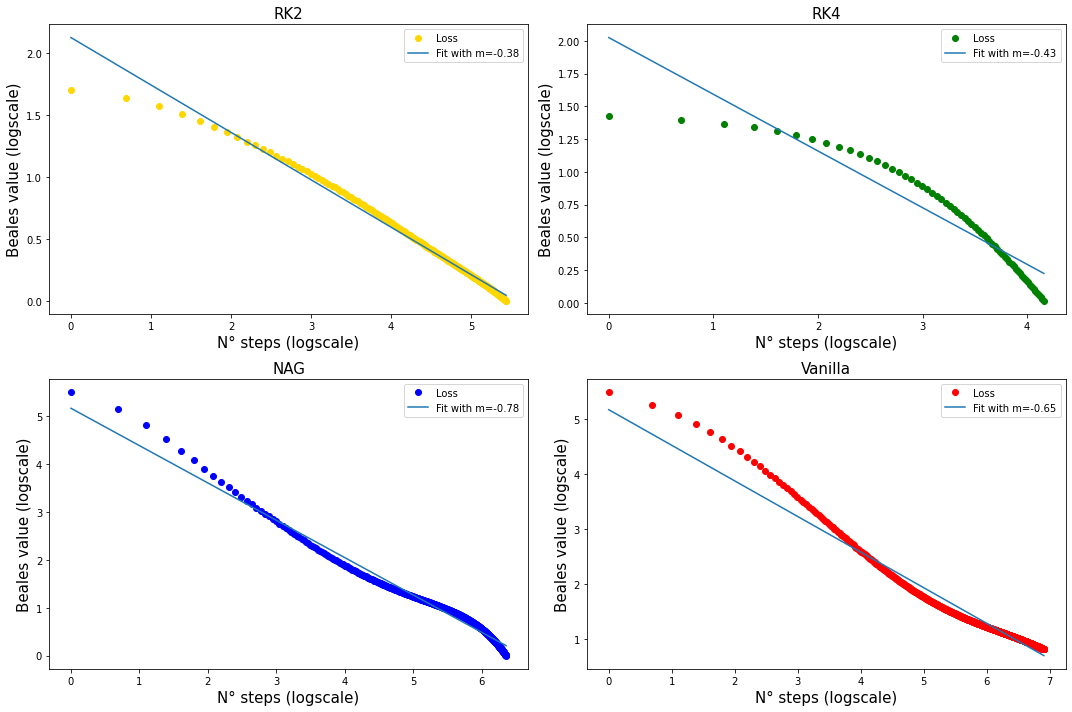

In [358]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.plot(x1, y1, 'o', color = "gold")
ax1.plot(x1, m1*x1 + q1) 
ax1.set_title("RK2",fontsize=15)
ax1.set_xlabel("N° steps (logscale)",fontsize=15)
ax1.set_ylabel("Beales value (logscale)",fontsize=15)
ax1.legend(['Loss',('Fit with m={}').format(round(m1,2))],loc=1)

ax2.plot(x2, y2, 'o', color = "green")
ax2.plot(x2, m2*x2 + q2)
ax2.set_title("RK4",fontsize=15)
ax2.set_xlabel("N° steps (logscale)",fontsize=15)
ax2.set_ylabel("Beales value (logscale)",fontsize=15)
ax2.legend(['Loss',('Fit with m={}').format(round(m2,2))],loc=1)

ax3.plot(x3, y3, 'o', color = "blue")
ax3.plot(x3, m3*x3 + q3) 
ax3.set_title("NAG",fontsize=15)
ax3.set_xlabel("N° steps (logscale)",fontsize=15)
ax3.set_ylabel("Beales value (logscale)",fontsize=15)
ax3.legend(['Loss',('Fit with m={}').format(round(m3,2))],loc=1)

ax4.plot(x4, y4, 'o', color = "red")
ax4.plot(x4, m4*x4 + q4)
ax4.set_title("Vanilla",fontsize=15)
ax4.set_xlabel("N° steps (logscale)",fontsize=15)
ax4.set_ylabel("Beales value (logscale)",fontsize=15)
ax4.legend(['Loss',('Fit with m={}').format(round(m4,2))],loc=1)

fig.tight_layout()
plt.show()